In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns

from bioinfokit.analys import stat
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes
from sklearn.decomposition import PCA
np.random.seed(123)

import warnings
warnings.filterwarnings('ignore')

In [2]:
file = pd.ExcelFile('Cleaned.xlsx')
df1 = pd.read_excel(file, 'Transactions')
df2 = pd.read_excel(file, 'CustDemo')
df3 = pd.read_excel(file, 'NewCust')
df4 = pd.read_excel(file, 'CustAddresses')

In [3]:
df = df1.join(df2, how='left', on='customer_id', rsuffix='_cd')
df = df.join(df4, how='left', on='customer_id', rsuffix='_add')

In [4]:
df.columns

Index(['transaction_id', 'product_id', 'customer_id', 'transaction_date',
       'online_order', 'order_status', 'brand', 'product_line',
       'product_class', 'product_size', 'list_price', 'standard_cost',
       'product_first_sold_date', 'season', 'Sale_revenue', 'customer_id_cd',
       'first_name', 'last_name', 'gender',
       'past_3_years_bike_related_purchases', 'DOB', 'job_title',
       'job_industry_category', 'wealth_segment', 'deceased_indicator',
       'owns_car', 'tenure', 'age', 'agebin', 'customer_id_add', 'address',
       'postcode', 'state', 'country', 'property_valuation', 'metro'],
      dtype='object')

In [5]:
df = df[['customer_id', 'online_order', 'brand', 'product_line', 'product_class', 'product_size', 'list_price', 'standard_cost',
         'season', 'Sale_revenue', 'gender', 'past_3_years_bike_related_purchases', 'job_industry_category', 'wealth_segment', 
         'owns_car', 'tenure', 'age', 'agebin', 'postcode', 'state', 'property_valuation', 'metro']]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19625 entries, 0 to 19999
Data columns (total 22 columns):
customer_id                            19625 non-null int64
online_order                           19273 non-null float64
brand                                  19625 non-null object
product_line                           19625 non-null object
product_class                          19625 non-null object
product_size                           19625 non-null object
list_price                             19625 non-null float64
standard_cost                          19625 non-null float64
season                                 19625 non-null object
Sale_revenue                           19625 non-null float64
gender                                 19121 non-null object
past_3_years_bike_related_purchases    19121 non-null float64
job_industry_category                  15930 non-null object
wealth_segment                         19121 non-null object
owns_car                         

In [7]:
#Need a target - avg customer profit margin in 2017

df['profit_margin'] = (df['list_price'] - df['standard_cost']) / df['list_price']

a = {}
for i in set(df['customer_id']):
    x = df[df['customer_id'] == i]
    y = x['profit_margin'].mean()
    a[i] = y
    
df['avg_cust_pm'] = [a[i] for i in df['customer_id']]
df.describe()

,customer_id,online_order,list_price,standard_cost,Sale_revenue,past_3_years_bike_related_purchases,tenure,age,postcode,property_valuation,metro,profit_margin,avg_cust_pm
count,19625.000000,19273.000000,19625.000000,19625.000000,19625.000000,19121.000000,19121.000000,19121.000000,19622.000000,19622.000000,19622.000000,19625.000000,19625.000000
mean,1739.572994,0.500285,1107.744983,555.821210,551.923772,49.161602,10.703363,42.480989,2990.154928,7.543879,0.767353,0.446117,0.446117
std,1011.957495,0.500013,582.989189,405.977243,493.502909,28.463173,5.676916,12.602628,853.585870,2.820612,0.422530,0.264268,0.114344
min,1.000000,0.000000,12.010000,7.210000,4.800000,0.000000,1.000000,18.000000,2000.000000,1.000000,0.000000,0.072214,0.072214
25%,858.000000,0.000000,575.270000,215.140000,133.780000,25.000000,6.000000,33.000000,2200.000000,6.000000,1.000000,0.249973,0.366861
50%,1737.000000,1.000000,1163.890000,507.580000,445.210000,48.000000,11.000000,43.000000,2767.000000,8.000000,1.000000,0.399998,0.441426
75%,2615.000000,1.000000,1635.300000,795.100000,830.240000,73.000000,15.000000,52.000000,3775.000000,10.000000,1.000000,0.676080,0.518660
max,5034.000000,1.000000,2091.470000,1759.850000,1702.550000,99.000000,22.000000,88.000000,4883.000000,12.000000,1.000000,0.989604,0.989604


In [8]:
df['Target'] = ['Low' if i < 0.37 else 'Below_Avg' if i < 0.44 else 'Above_Avg' if i < 0.52 else 'High' for i in df['avg_cust_pm']]
#Check for class balance
df.Target.value_counts()

Low          5089
Above_Avg    5082
High         4814
Below_Avg    4640
Name: Target, dtype: int64

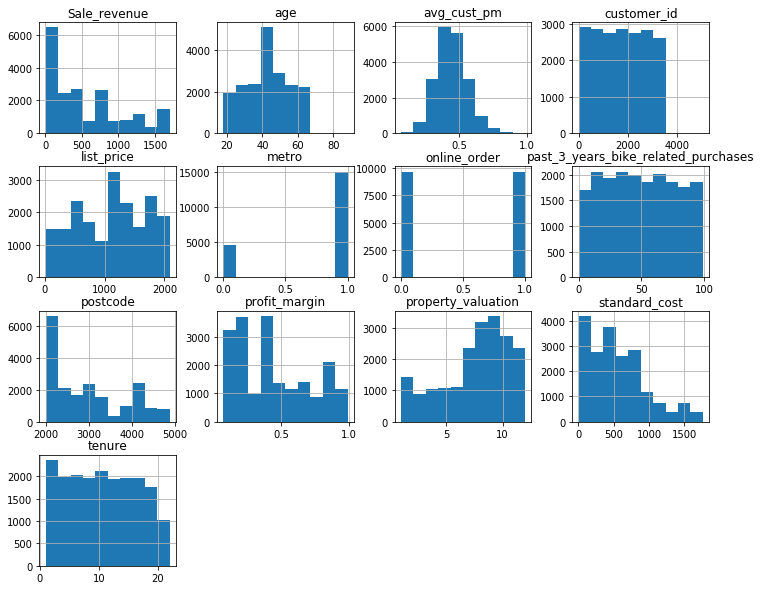

In [9]:
feat = df
feat.hist(figsize=(12,10));

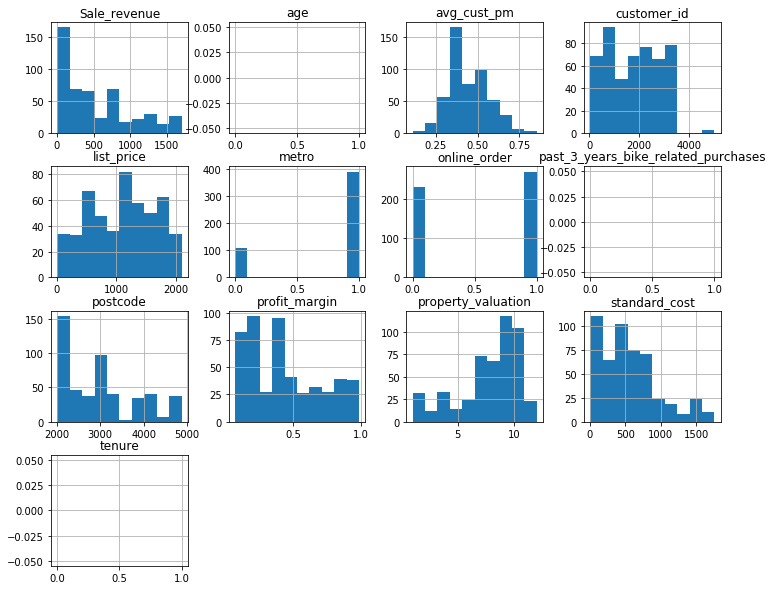

In [10]:
feat = df[df['gender'].isna()]
feat.hist(figsize=(12,10));

In [11]:
#remove rows with missing values
df = df[~df['gender'].isna()]

In [12]:
df.head(2)

,customer_id,online_order,brand,product_line,product_class,product_size,list_price,standard_cost,season,Sale_revenue,...,tenure,age,agebin,postcode,state,property_valuation,metro,profit_margin,avg_cust_pm,Target
0,2950,0.0,Solex,Standard,medium,medium,71.49,53.62,Winter,17.87,...,12.0,42.0,"[35, 45)",2765.0,NSW,9.0,1.0,0.249965,0.314974,Low
1,3120,1.0,Trek Bicycles,Standard,medium,large,2091.47,388.92,Spring,1702.55,...,19.0,61.0,"[55, 110)",2500.0,NSW,8.0,1.0,0.814045,0.430668,Below_Avg


In [29]:
#Chi Squared
dfx2 = df.copy()

In [30]:
dfx2.gender.value_counts()

Female    9868
Male      9253
Name: gender, dtype: int64

In [31]:
dfx2.columns

Index(['customer_id', 'online_order', 'brand', 'product_line', 'product_class',
       'product_size', 'list_price', 'standard_cost', 'season', 'Sale_revenue',
       'gender', 'past_3_years_bike_related_purchases',
       'job_industry_category', 'wealth_segment', 'owns_car', 'tenure', 'age',
       'agebin', 'postcode', 'state', 'property_valuation', 'metro',
       'profit_margin', 'avg_cust_pm', 'Target'],
      dtype='object')

In [35]:
dfx2.pivot_table(index='Target', columns='gender', aggfunc='count')

Sale_revenue          age       agebin       avg_cust_pm        \
gender          Female  Male Female  Male Female  Male      Female  Male   
Target                                                                     
Above_Avg         2693  2284   2693  2284   2693  2284        2693  2284   
Below_Avg         2211  2300   2211  2300   2211  2300        2211  2300   
High              2488  2205   2488  2205   2488  2205        2488  2205   
Low               2476  2464   2476  2464   2476  2464        2476  2464   

           brand        ...  season       standard_cost        state        \
gender    Female  Male  ...  Female  Male        Female  Male Female  Male   
Target                  ...                                                  
Above_Avg   2693  2284  ...    2693  2284          2693  2284   2693  2284   
Below_Avg   2211  2300  ...    2211  2300          2211  2300   2211  2300   
High        2488  2205  ...    2488  2205          2488  2205   2488  2205   
Low         2476  2464  ...    2476  2464          2476  2464   2476  2464   

          tenure       wealth_segment        
gender    Female  Male         Female  Male  
Target                                       
Above_Avg   2693  2284           2693  2284  
Below_Avg   2211  2300           2211  2300  
High        2488  2205           2488  2205  
Low         2476  2464           2476  2464  

[4 rows x 46 columns]

In [38]:
dfx = pd.DataFrame({'Target': ['Above_Avg', 'Below_Avg', 'High', 'Low'], 'Female': [2693,2211,2488,2476], 'Male':[2284,2300,2205,2464]})
dfx = dfx.set_index('Target')

dfx

,Female,Male
Target,,
Above_Avg,2693,2284
Below_Avg,2211,2300
High,2488,2205
Low,2476,2464


In [40]:
res = stat()
res.chisq(df=dfx)
print(res.summary)
print(res.expected_df)


Chi-squared test for independence

Test              Df    Chi-square      P-value
--------------  ----  ------------  -----------
Pearson            3       32.7148  3.69919e-07
Log-likelihood     3       32.7259  3.67922e-07


Expected frequency counts

      Female     Male
--  --------  -------
 0   2568.54  2408.46
 1   2328.04  2182.96
 2   2421.97  2271.03
 3   2549.44  2390.56



In [ ]:
data = df2.join(df4, how='left', on='customer_id', rsuffix='_add')
len(data)

In [ ]:
df = df.drop_duplicates(['customer_id'])

In [ ]:
data = data.merge(df[['customer_id', 'avg_cust_pm']], on='customer_id', how='left')
len(data)

In [ ]:
data.iloc[0]

In [ ]:
data1 = data[['gender', 'past_3_years_bike_related_purchases', 'job_industry_category', 'wealth_segment', 
              'owns_car', 'tenure', 'agebin', 'state', 'property_valuation', 'metro', 'avg_cust_pm']]

In [ ]:
#Set dummy variables for categorical data and check for multicolinearity

# Of those, these are all of the variables that are categorical.
a = ['gender', 'job_industry_category', 'wealth_segment', 'owns_car', 'agebin', 'state', 'metro']

#Generating a dictionary where the key is the column name and the value
#is a DF of dummy variable columns, dropping the first instance to avoid
#multicollinearity
b = {}
for i in a:
    b[i] = pd.get_dummies(data1[i], prefix=i, drop_first=True)

len(data1)

In [ ]:
data1 = data1.drop(a, axis=1)
len(data1)

In [ ]:
len(data1)

In [ ]:
for key in b:
    data1 = pd.merge(data1, b[key],
                     how='inner', left_on=data1.index,
                     right_on = b[key].index)
    data1 = data1.drop('key_0', axis=1)

print(len(data1))
#view the columns to ensure I completed the dummy columns correctly
data1.columns

In [ ]:
correlation = abs(round(data1.corr(), 2))
f, ax = plt.subplots(figsize=(25,25))
sns.heatmap(correlation, annot = True, square=True, cmap =sns.diverging_palette(220, 10, as_cmap=True))
plt.title('Correlation Heatmap',fontweight='bold',fontsize=15)
plt.show();

In [ ]:
data.columns

In [ ]:
data2 = data[['avg_cust_pm', 'gender', 'wealth_segment', 'owns_car', 'agebin', 'state', 'property_valuation', 'metro']]
data2 = data2[~data2['avg_cust_pm'].isna()]

In [ ]:
kp = KPrototypes(n_clusters=4, init='Huang', n_init=15, verbose=1)
kpclusters = kp.fit_predict(data2, categorical=[1,2,3,4,5,6,7])
#km = KModes(n_clusters=6, init='Huang', n_init=15, verbose=1)
#clusters = km.fit_predict(data2)

In [ ]:
print(kp.cluster_centroids_)

In [ ]:
print(km.cluster_centroids_)

In [ ]:
data = df.copy()

In [ ]:
#Set dummy variables for categorical data and check for multicolinearity

# Of those, these are all of the variables that are categorical.
a = ['gender', 'wealth_segment', 'owns_car', 'state', 'property_valuation', 'agebin', 'metro', 'online_order', 'brand', 
     'product_line', 'product_class', 'product_size', 'season']

#Generating a dictionary where the key is the column name and the value
#is a DF of dummy variable columns, dropping the first instance to avoid
#multicollinearity
b = {}
for i in a:
    b[i] = pd.get_dummies(df[i], prefix=i, drop_first=True)

In [ ]:
#drop the columns I created dummys for
df = df.drop(a, axis=1)

In [ ]:
#merging the dummy DFs to the original data frame and dropping the index column
#from each merge
for key in b:
    df = pd.merge(df, b[key],
                 how='left',
                 left_on=df.index,
                 right_on = b[key].index)
    df = df.drop('key_0', axis=1)

print(len(df))
#view the columns to ensure I completed the dummy columns correctly
df.columns

In [ ]:
correlation = abs(round(df.corr(), 2))
f, ax = plt.subplots(figsize=(25,25))
sns.heatmap(correlation, annot = True, square=True, cmap =sns.diverging_palette(220, 10, as_cmap=True))
plt.title('Correlation Heatmap',fontweight='bold',fontsize=15)
plt.show();

In [ ]:
#Sale Revenue is the only variable the crosses the standard 0.75 threshold.
df = df.drop(['Sale_revenue', 'product_line_Standard'], axis=1)

In [ ]:
df['past_3_years_bike_related_purchases'] = df['past_3_years_bike_related_purchases'].astype('float')

In [ ]:
#df['postcode'] = df.postcode.astype('str')

In [ ]:
df.info()

In [ ]:
df_lr = df[['Target', 'past_3_years_bike_related_purchases', 'tenure', 'age', 'gender_Male', 
            'wealth_segment_High Net Worth', 'wealth_segment_Mass Customer', 'owns_car_Yes', 'state_QLD',
            'state_VIC', 'property_valuation_2.0', 'property_valuation_3.0', 'property_valuation_4.0', 
            'property_valuation_5.0', 'property_valuation_6.0', 'property_valuation_7.0', 'property_valuation_8.0', 
            'property_valuation_9.0', 'property_valuation_10.0', 'property_valuation_11.0', 'property_valuation_12.0', 
            'agebin_[25, 35)', 'agebin_[35, 45)', 'agebin_[45, 55)', 'agebin_[55, 110)', 'metro_1.0', 
            'online_order_1.0', 'brand_Norco Bicycles', 'brand_OHM Cycles', 'brand_Solex', 'brand_Trek Bicycles', 
            'brand_WeareA2B', 'product_line_Road', 'product_line_Touring', 'product_class_low', 'product_class_medium',
            'product_size_medium', 'product_size_small', 'season_Spring', 'season_Summer', 'season_Winter']]

In [ ]:
#from sklearn import svm, tree
#from sklearn.decomposition import PCA
#from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix
from sklearn.metrics import classification_report, roc_auc_score, recall_score, precision_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
#from sklearn.pipeline import Pipeline, make_pipeline
#from sklearn.preprocessing import LabelEncoder, StandardScaler
#from sklearn.tree import DecisionTreeClassifier, export_graphviz
#from xgboost import XGBClassifier

In [ ]:
df_lr = df_lr.dropna()
len(df_lr)

In [ ]:
y = df_lr.Target
X = df_lr.drop(['Target'], axis=1)

print(len(y))
print(len(X))

In [ ]:
#X = X.reset_index()
features = [i for i in X.columns]

#Here I am using a Standard Scaler to scale the continuous varaibles in the data.
X = StandardScaler().fit_transform(X)
#b = pd.DataFrame(data=a, columns=features)
#X = X.drop(features, axis=1)
#X = X.merge(b, left_index=True, right_index=True)
#X = X.set_index('encounter_id')

print(len(y))
print(len(X))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

print(y_train.value_counts())

print(y_test.value_counts())

In [ ]:
lrX_train = X_train
lrX_test = X_test
lry_train = y_train
lry_test = y_test

In [ ]:
logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='newton-cg')
model_log = logreg.fit(lrX_train, lry_train)
print(model_log)

#setting the predicted train and test sets
lry_hat_train = logreg.predict(lrX_train)
lry_hat_test = logreg.predict(lrX_test)

#because the target is currently set to 'Readmit' and 'No_readmit' I need
#to code them as 0 and 1.
lry_train = np.array([0 if i == 'High' else 1 if i == 'Above_Avg' else 2 if i == 'Below_Avg' else 3 for i in lry_train])
lry_hat_train = np.array([0 if i == 'High' else 1 if i == 'Above_Avg' else 2 if i == 'Below_Avg' else 3 for i in lry_hat_train])


#Calculate the residuals for the training set
residuals = np.abs(lry_train - lry_hat_train)
print('------------------------------------\tTraining Accuracy')
print(pd.Series(residuals).value_counts())
print(pd.Series(residuals).value_counts(normalize=True))


lry_test = np.array([0 if i == 'High' else 1 if i == 'Above_Avg' else 2 if i == 'Below_Avg' else 3 for i in lry_test])
lry_hat_test = np.array([0 if i == 'High' else 1 if i == 'Above_Avg' else 2 if i == 'Below_Avg' else 3 for i in lry_hat_test])

#Calculate the residuals for the testing set
residuals = np.abs(lry_test - lry_hat_test)
print('------------------------------------\tTesting Accuracy')
print(pd.Series(residuals).value_counts())
print(pd.Series(residuals).value_counts(normalize=True))

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    # Check if normalize is set to True
    # If so, normalize the raw confusion matrix before visualizing
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    #This generates a 2D display
    plt.imshow(cm, cmap=cmap)
    
    # Add title and axis labels 
    plt.title(title) 
    plt.ylabel('True label') 
    plt.xlabel('Predicted label')
    
    # Add appropriate axis scales
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Text formatting
    fmt = '.2f' if normalize else 'd'
    # Add labels to each cell
    thresh = cm.max() / 2.
    # Here I iterate through the confusion matrix and append labels to our visualization 
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')
    
    # Add a legend
    plt.colorbar()
    plt.show()

In [ ]:
import itertools
class_names = set(y) 

#generate values for the CM
cnf_mat_logreg = confusion_matrix(lry_test, lry_hat_test) 

#plot
plot_confusion_matrix(cnf_mat_logreg, classes=class_names, normalize=True)

In [ ]:
#gender, industry, wealth segment, owns car, tenure, state, postcode, prop_val, age/agebin, metro

In [ ]:
df = df[['Target', 'past_3_years_bike_related_purchases', 'tenure', 'age', 'gender_Male', 
         'wealth_segment_High Net Worth', 'wealth_segment_Mass Customer', 'owns_car_Yes', 'state_QLD', 'state_VIC', 
         'property_valuation_2.0', 'property_valuation_3.0', 'property_valuation_4.0', 'property_valuation_5.0', 'property_valuation_6.0', 
         'property_valuation_7.0', 'property_valuation_8.0', 'property_valuation_9.0', 'property_valuation_10.0', 'property_valuation_11.0',
         'property_valuation_12.0', 'agebin_[25, 35)', 'agebin_[35, 45)', 'agebin_[45, 55)', 'agebin_[55, 110)', 'metro_1.0' ]]

In [ ]:
df = df.dropna()
y = df['Target']
X = df.drop(['Target'], axis=1)
scaler = StandardScaler()
scaled_df = scaler.fit_transform(X)

In [ ]:
scaled_k_means = KMeans(n_clusters=2)
scaled_k_means.fit(scaled_df)
scaled_preds = scaled_k_means.predict(scaled_df)

In [ ]:
from sklearn.metrics import adjusted_rand_score
adjusted_rand_score(y, scaled_preds)

In [ ]:
pca = PCA(n_components=6)
pca_df = pca.fit_transform(scaled_df)

In [ ]:
np.cumsum(pca.explained_variance_ratio_)

In [ ]:
pca_k_means = KMeans(n_clusters=4)
pca_k_means.fit(pca_df)
pca_preds = pca_k_means.predict(pca_df)

adjusted_rand_score(y, pca_preds)

In [ ]:
len(df)